<a href="https://colab.research.google.com/github/bishair/Pirna/blob/main/G10-WithoutRetraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import display
import joblib


In [3]:
uploaded_file = files.upload()

Saving riverL.xlsx to riverL.xlsx


In [4]:
# Read the groundwater level data
gw_data = pd.read_excel('groundwater.xlsx')
gw_data.dropna(inplace=True)
gw_data['Date'] = pd.to_datetime(gw_data['Date'], format='%d/%m/%Y %H:%M')
print(gw_data)

# Read the river water level data
river_data = pd.read_excel('riverL.xlsx')
river_data['Date'] = pd.to_datetime(river_data['Date'], format='%d/%m/%Y %H:%M')

# Merge the two datasets on the 'Date' column
merged_data = pd.merge_asof(gw_data.sort_values('Date'), river_data.sort_values('Date'), on='Date', direction='nearest')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

resampled_data = merged_data.resample('H').ffill()
resampled_data = resampled_data[1:]
print(resampled_data)

'''
has_nan = resampled_data.isna().any().any()
print(has_nan)
total_nan_count = resampled_data.isna().sum().sum()
print(total_nan_count)
nan_per_column = resampled_data.isna().any()
print(nan_per_column)
nan_count_per_column = resampled_data.isna().sum()
print(nan_count_per_column)'''


                     Date      G10
0     2015-01-30 12:18:00  110.722
1     2015-01-30 13:18:00  110.720
2     2015-01-30 14:18:00  110.718
3     2015-01-30 15:18:00  110.715
4     2015-01-30 16:18:00  110.714
...                   ...      ...
17533 2017-01-30 10:19:00  109.456
17534 2017-01-30 11:19:00  109.455
17535 2017-01-30 12:19:00  109.456
17536 2017-01-30 13:19:00  109.457
17537 2017-01-30 14:19:00  109.459

[17329 rows x 2 columns]
                         G10  River
Date                               
2015-01-30 13:00:00  110.722  261.0
2015-01-30 14:00:00  110.720  260.0
2015-01-30 15:00:00  110.718  260.0
2015-01-30 16:00:00  110.715  260.0
2015-01-30 17:00:00  110.714  260.0
...                      ...    ...
2017-01-30 10:00:00  109.457  135.0
2017-01-30 11:00:00  109.456  136.0
2017-01-30 12:00:00  109.455  138.0
2017-01-30 13:00:00  109.456  141.0
2017-01-30 14:00:00  109.457  144.0

[17546 rows x 2 columns]


'\nhas_nan = resampled_data.isna().any().any()\nprint(has_nan)\ntotal_nan_count = resampled_data.isna().sum().sum()\nprint(total_nan_count)\nnan_per_column = resampled_data.isna().any()\nprint(nan_per_column)\nnan_count_per_column = resampled_data.isna().sum()\nprint(nan_count_per_column)'

In [5]:

n_steps = 24

# Assume merged_data is a DataFrame with 'Date' as index
merged_data_copy = merged_data.copy()
merged_data_copy.reset_index(inplace=True)
dates = merged_data_copy['Date']

# Split the merged data (70% training, 30% testing)
train_size = int(len(merged_data) * 0.7)
merged_data_train = merged_data[:train_size]
merged_data_test = merged_data[train_size:]

# Split dates corresponding to the data split
dates_train = dates[:train_size]
dates_test = dates[train_size:]

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(merged_data_train)
test_scaled = scaler.transform(merged_data_test)

# Save the scaler for future use
joblib.dump(scaler, 'scaler.gz')

def create_sequences_with_dates(data, dates, n_steps):
    """
    Create sequences along with corresponding dates.
    """
    X, y, dates_seq = [], [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 0])
        # Capture the full range of dates for each sequence
        dates_seq.append(dates.iloc[i - n_steps + 1 : i + 1])
    return np.array(X), np.array(y), np.array(dates_seq)

# Create sequences for training and testing sets
X_train, y_train, dates_train_seq = create_sequences_with_dates(train_scaled, dates_train, n_steps)
X_test, y_test, dates_test_seq = create_sequences_with_dates(test_scaled, dates_test, n_steps)

# Print shapes of X_train, y_train, X_test, y_test for verification
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print(dates_test_seq)

X_train shape: (12106, 24, 2)
y_train shape: (12106,)
X_test shape: (5175, 24, 2)
y_test shape: (5175,)
[['2016-06-19T16:13:00.000000000' '2016-06-19T17:13:00.000000000'
  '2016-06-19T18:13:00.000000000' ... '2016-06-20T13:13:00.000000000'
  '2016-06-20T14:13:00.000000000' '2016-06-20T15:13:00.000000000']
 ['2016-06-19T17:13:00.000000000' '2016-06-19T18:13:00.000000000'
  '2016-06-19T19:13:00.000000000' ... '2016-06-20T14:13:00.000000000'
  '2016-06-20T15:13:00.000000000' '2016-06-20T16:13:00.000000000']
 ['2016-06-19T18:13:00.000000000' '2016-06-19T19:13:00.000000000'
  '2016-06-19T20:13:00.000000000' ... '2016-06-20T15:13:00.000000000'
  '2016-06-20T16:13:00.000000000' '2016-06-20T17:13:00.000000000']
 ...
 ['2017-01-29T13:19:00.000000000' '2017-01-29T14:19:00.000000000'
  '2017-01-29T15:19:00.000000000' ... '2017-01-30T10:19:00.000000000'
  '2017-01-30T11:19:00.000000000' '2017-01-30T12:19:00.000000000']
 ['2017-01-29T14:19:00.000000000' '2017-01-29T15:19:00.000000000'
  '2017-01-29

In [6]:
print(X_train, X_train.shape)

[[[0.8510427  0.66666667]
  [0.85004965 0.66287879]
  [0.8490566  0.66287879]
  ...
  [0.83366435 0.65909091]
  [0.8326713  0.65909091]
  [0.83118173 0.66287879]]

 [[0.85004965 0.66287879]
  [0.8490566  0.66287879]
  [0.84756703 0.66287879]
  ...
  [0.8326713  0.65909091]
  [0.83118173 0.66287879]
  [0.83118173 0.66666667]]

 [[0.8490566  0.66287879]
  [0.84756703 0.66287879]
  [0.84707051 0.66287879]
  ...
  [0.83118173 0.66287879]
  [0.83118173 0.66666667]
  [0.82969215 0.67045455]]

 ...

 [[0.32820258 0.36363636]
  [0.3306852  0.35984848]
  [0.3346574  0.35984848]
  ...
  [0.36494538 0.36363636]
  [0.36693148 0.35984848]
  [0.36842105 0.35984848]]

 [[0.3306852  0.35984848]
  [0.3346574  0.35984848]
  [0.3366435  0.35606061]
  ...
  [0.36693148 0.35984848]
  [0.36842105 0.35984848]
  [0.36891758 0.35606061]]

 [[0.3346574  0.35984848]
  [0.3366435  0.35606061]
  [0.33912612 0.35227273]
  ...
  [0.36842105 0.35984848]
  [0.36891758 0.35606061]
  [0.36991063 0.35606061]]] (12106, 24

In [7]:
print(X_test, X_test.shape)

[[[0.37239325 0.35227273]
  [0.37288977 0.35227273]
  [0.3733863  0.35227273]
  ...
  [0.38331678 0.34848485]
  [0.38381331 0.34848485]
  [0.38430983 0.34469697]]

 [[0.37288977 0.35227273]
  [0.3733863  0.35227273]
  [0.37487587 0.35227273]
  ...
  [0.38381331 0.34848485]
  [0.38430983 0.34469697]
  [0.38480636 0.34469697]]

 [[0.3733863  0.35227273]
  [0.37487587 0.35227273]
  [0.37586892 0.35227273]
  ...
  [0.38430983 0.34469697]
  [0.38480636 0.34469697]
  [0.38480636 0.34090909]]

 ...

 [[0.2428004  0.21212121]
  [0.2428004  0.20833333]
  [0.24230387 0.20454545]
  ...
  [0.22293942 0.18939394]
  [0.2224429  0.19318182]
  [0.22194638 0.20075758]]

 [[0.2428004  0.20833333]
  [0.24230387 0.20454545]
  [0.24180735 0.1969697 ]
  ...
  [0.2224429  0.19318182]
  [0.22194638 0.20075758]
  [0.2224429  0.21212121]]

 [[0.24230387 0.20454545]
  [0.24180735 0.1969697 ]
  [0.2408143  0.19318182]
  ...
  [0.22194638 0.20075758]
  [0.2224429  0.21212121]
  [0.22293942 0.22348485]]] (5175, 24,

In [8]:
print(y_train, y_train.shape)

[0.83118173 0.82969215 0.82969215 ... 0.36891758 0.36991063 0.3714002 ] (12106,)


In [9]:
print(y_test, y_test.shape)

[0.38480636 0.38480636 0.38629593 ... 0.2224429  0.22293942 0.22393247] (5175,)


In [10]:
input_shape=(X_train.shape[1], X_train.shape[2])

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l1_l2

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=input_shape,   #input shape => (timesteps, features).  X => (samples, timesteps, features)
         dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.2),
    LSTM(units=50, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)


Epoch 1/50
190/190 [==============================] - 18s 63ms/step - loss: 0.1472
Epoch 2/50
190/190 [==============================] - 12s 64ms/step - loss: 0.0087
Epoch 3/50
190/190 [==============================] - 12s 63ms/step - loss: 0.0064
Epoch 4/50
190/190 [==============================] - 12s 63ms/step - loss: 0.0054
Epoch 5/50
190/190 [==============================] - 13s 70ms/step - loss: 0.0048
Epoch 6/50
190/190 [==============================] - 12s 64ms/step - loss: 0.0046
Epoch 7/50
190/190 [==============================] - 12s 63ms/step - loss: 0.0044
Epoch 8/50
190/190 [==============================] - 12s 63ms/step - loss: 0.0044
Epoch 9/50
190/190 [==============================] - 12s 64ms/step - loss: 0.0041
Epoch 10/50
190/190 [==============================] - 12s 64ms/step - loss: 0.0040
Epoch 11/50
190/190 [==============================] - 15s 76ms/step - loss: 0.0042
Epoch 12/50
190/190 [==============================] - 26s 137ms/step - loss: 0.0039


In [11]:
model.save('lstmmodel.h5')
model = load_model('lstmmodel.h5')
scaler = joblib.load('scaler.gz')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Function to retrain the model with new data
def retrain_model(model, X_new, y_new, epochs=5, batch_size=32):
    # Partial retraining of the model with new data
    model.fit(X_new, y_new, epochs=epochs, batch_size=batch_size, shuffle=True)
    return model

'''# Function to update y_train and recalculate statistics
def update_training_data(new_data, y_train, max_length=10000):
    updated_y_train = np.append(y_train, new_data)
    if len(updated_y_train) > max_length:
        updated_y_train = updated_y_train[-max_length:]
    mean_y_train = np.mean(updated_y_train)
    std_y_train = np.std(updated_y_train)
    return updated_y_train, mean_y_train, std_y_train '''

'# Function to update y_train and recalculate statistics\ndef update_training_data(new_data, y_train, max_length=10000):\n    updated_y_train = np.append(y_train, new_data)\n    if len(updated_y_train) > max_length:\n        updated_y_train = updated_y_train[-max_length:]\n    mean_y_train = np.mean(updated_y_train)\n    std_y_train = np.std(updated_y_train)\n    return updated_y_train, mean_y_train, std_y_train '

In [13]:
import numpy as np
import pandas as pd

window_size = 24
retrain_flag = False  # Set to False to compare without retraining

# Initializing lists to store results
actual_values = []
predicted_values = []
errors = []
anomaly_errors = []  # Track MSE for anomalies
dates_for_plotting = []
anomalies = []

#for i in range(min(360, X_test.shape[0])):
for i in range(X_test.shape[0]):
    X_input = X_test[i, :, :]
    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))

    forecast = model.predict(X_input)
    dummy = np.zeros((1, 2))
    dummy[:, 0] = forecast[:, 0]
    forecasted_value = scaler.inverse_transform(dummy)[0, 0]
    predicted_values.append(forecasted_value)

    actual = y_test[i] if i < len(y_test) else None
    if actual is not None:
        actual_transformed = scaler.inverse_transform([[actual, 0]])[0, 0]
        actual_values.append(actual_transformed)

    error = abs(forecasted_value - actual_transformed)
    errors.append(error)

    last_date = pd.to_datetime(dates_test_seq[i][-1])
    dates_for_plotting.append(last_date)

    if len(errors) >= window_size:
        windowed_errors = errors[-window_size:]
        mean_error = np.mean(windowed_errors)
        std_error = np.std(windowed_errors)
        threshold = mean_error + 2.5 * std_error

        windowed_anomalies = [j for j, e in enumerate(windowed_errors) if e > threshold]
        if windowed_anomalies:
            anomaly_indices = [i - window_size + 1 + j for j in windowed_anomalies]
            anomalies.extend(anomaly_indices)
            for idx in anomaly_indices:
                anomaly_errors.append((predicted_values[idx] - actual_values[idx]) ** 2)

            if retrain_flag:
                # Retrain the model with the most recent window of data
                model = retrain_model(model, X_test[i-window_size+1:i+1, :], y_test[i-window_size+1:i+1])

# Calculate and print MSE for anomalies
anomaly_mse = np.mean(anomaly_errors) if anomaly_errors else 0
print("MSE for Anomalies:", anomaly_mse)
print(actual_values)
print(predicted_values)
print(errors)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
MSE for Anomalies: 0.000942331291707596
[109.783, 109.783, 109.786, 109.785, 109.785, 109.784, 109.783, 109.78, 109.78, 109.778, 109.778, 109.775, 109.776, 109.773, 109.772, 109.769, 109.77, 109.767, 109.766, 109.766, 109.764, 109.765, 109.764, 109.765, 109.765, 109.766, 109.766, 109.767, 109.768, 109.768, 109.769, 109.77, 109.77, 109.773, 109.773, 109.775, 109.778, 109.779, 109.781, 109.782, 109.783, 109.785, 109.784, 109.782, 109.782, 109.779, 109.777, 109.776, 109.77, 109.767, 109.763, 109.76, 109.754, 109.752, 109.748, 109.745, 109.742, 109.739, 109.737, 109.736, 109.733, 109.731, 109.728, 109.728, 109.727, 109.724, 109.723, 109.722, 109.72, 109.718, 109.718, 109.716, 109.715, 109.713, 109.711, 109.709, 109.708, 109.706, 109.703, 109.702, 109.7, 109.698, 109.697, 109.694, 109.693, 109.691, 109.689, 109.687, 109.685, 109.686, 109.682, 109.681, 109.679, 109.677, 109.676, 109.674, 10

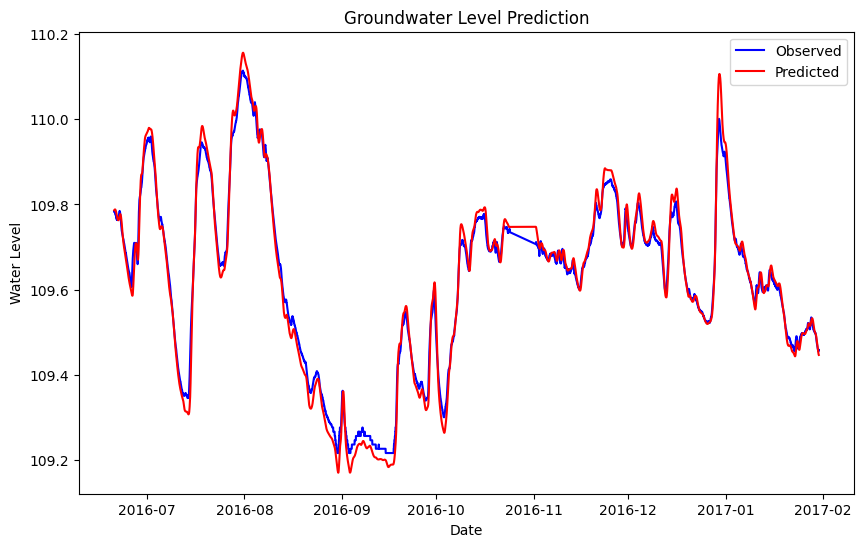

In [14]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(dates_for_plotting, actual_values, label='Observed', color='blue')
ax.plot(dates_for_plotting, predicted_values, label='Predicted', color='red')

ax.set_title('Groundwater Level Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Water Level')
ax.legend()

plt.show()


In [ ]:
'''window_size = 24
retrain_flag = True  # Set this to False to compare without retraining

actual_values = []
predicted_values = []
errors = []
anomaly_errors = []  # Track MSE for anomalies
dates_for_plotting = []
anomalies = []

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(X_test.shape[0]):
    X_input = X_test[i, :, :]
    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))

    forecast = model.predict(X_input)
    dummy = np.zeros((1, 2))
    dummy[:, 0] = forecast[:, 0]
    forecasted_value = scaler.inverse_transform(dummy)[0, 0]  # Inverse transform
    predicted_values.append(forecasted_value)  # Store inverse-transformed predicted value

    actual = y_test[i] if i < len(y_test) else None
    if actual is not None:
        actual_transformed = scaler.inverse_transform([[actual, 0]])[0, 0]  # Inverse transform
        actual_values.append(actual_transformed)  # Store inverse-transformed actual value

    error = abs(forecasted_value - actual_transformed)
    errors.append(error)

    last_date = pd.to_datetime(dates_test_seq[i][-1])
    dates_for_plotting.append(last_date)

    ax.clear()
    ax.plot(dates_for_plotting, actual_values, label='Observed', color='blue')  # These are inverse-transformed
    ax.plot(dates_for_plotting, predicted_values, label='Predicted', color='red')  # These are inverse-transformed
    ax.scatter([dates_for_plotting[j] for j in anomalies], [actual_values[j] for j in anomalies], color='orange', label='Anomalies')
    ax.set_title('Groundwater Level Prediction')
    ax.set_xlabel('Date')
    ax.set_ylabel('Water Level')
    ax.legend()

    if len(errors) >= window_size:
        windowed_errors = errors[-window_size:]
        mean_error = np.mean(windowed_errors)
        std_error = np.std(windowed_errors)
        threshold = mean_error + 3 * std_error

        windowed_anomalies = [j for j, e in enumerate(windowed_errors) if e > threshold]
        if windowed_anomalies:
            anomaly_indices = [i - window_size + 1 + j for j in windowed_anomalies]
            anomalies.extend(anomaly_indices)
            for idx in anomaly_indices:
                anomaly_errors.append((predicted_values[idx] - actual_values[idx])**2)

            if retrain_flag:
                # Retrain the model with the most recent window of data
                model = retrain_model(model, X_test[i-window_size+1:i+1, :], y_test[i-window_size+1:i+1])

    display(fig)
    plt.pause(0.5)
    clear_output(wait=True)

plt.close(fig)

# Calculate and print MSE for anomalies
anomaly_mse = np.mean(anomaly_errors) if anomaly_errors else 0
print("MSE for Anomalies:", anomaly_mse)'''

'window_size = 24\nretrain_flag = True  # Set this to False to compare without retraining\n\nactual_values = []\npredicted_values = []\nerrors = []\nanomaly_errors = []  # Track MSE for anomalies\ndates_for_plotting = []\nanomalies = []\n\nfig, ax = plt.subplots(figsize=(10, 6))\n\nfor i in range(X_test.shape[0]):\n    X_input = X_test[i, :, :]\n    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))\n\n    forecast = model.predict(X_input)\n    dummy = np.zeros((1, 2))\n    dummy[:, 0] = forecast[:, 0]\n    forecasted_value = scaler.inverse_transform(dummy)[0, 0]  # Inverse transform\n    predicted_values.append(forecasted_value)  # Store inverse-transformed predicted value\n\n    actual = y_test[i] if i < len(y_test) else None\n    if actual is not None:\n        actual_transformed = scaler.inverse_transform([[actual, 0]])[0, 0]  # Inverse transform\n        actual_values.append(actual_transformed)  # Store inverse-transformed actual value\n\n    error = abs(foreca